In [1]:
import seaborn as sns
import gc

from shared.utils import *
from shared.local_path import *

from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Data Preprocessing
## Read Audio Data

In [ ]:
label = []
filepath = []

for classes in os.listdir(AUDIO_PATH):
    for file in os.listdir(os.path.join(AUDIO_PATH, classes)):
        file_path = os.path.join(AUDIO_PATH, classes, file)

        filepath.append(file_path)
        label.append(classes)

audio = pd.DataFrame({
    'filepath': filepath,
    'label': label,
})

del filepath, label

audio.head()

In [ ]:
le = LabelEncoder()
le.fit(audio['label'])
audio['label_encoded'] = le.transform(audio['label'])
num_classes = len(le.classes_)

## Read Image Data

In [ ]:
filepath = []
label = []

i = 0
for classes in os.listdir(TRAIN_IMAGE_PATH):
    for file in os.listdir(os.path.join(TRAIN_IMAGE_PATH, classes)):
        path = os.path.join(TRAIN_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

train_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(train_df.shape)
print(train_df['label'].unique())
train_df.head()

In [ ]:
filepath = []
label = []

i = 0
for classes in os.listdir(TEST_IMAGE_PATH):
    for file in os.listdir(os.path.join(TEST_IMAGE_PATH, classes)):
        path = os.path.join(TEST_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

img_test_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(img_test_df.shape)
print(img_test_df['label'].unique())
img_test_df.head()

In [ ]:
le = LabelEncoder()
le.fit(train_df['label'])
train_df['label_encoded'] = le.transform(train_df['label'])
img_test_df['label_encoded'] = le.transform(img_test_df['label'])

## transform the filepath into image data

In [ ]:
with tf.device('/GPU:0'):
    audio['data'] = audio.filepath.apply(preprocess_audio)
    
tf.keras.backend.clear_session()
gc.collect()

with tf.device('/GPU:0'):
    train_df['data'] = train_df['filepath'].apply(
        lambda x: preprocess_image(x, (100, 100), preprocess_function=tf.keras.applications.vgg19.preprocess_input, augment=True))
    img_test_df['data'] = img_test_df['filepath'].apply(
        lambda x: preprocess_image(x, (100, 100), preprocess_function=tf.keras.applications.vgg19.preprocess_input)
    )
    

## Split and Shuffle Dataset into train, val, and test

In [ ]:
# Audio Data
audio = audio.sample(frac=1).reset_index(drop=True)
_, aud_temp = train_test_split(audio, test_size=0.5, random_state=42)
aud_val_df, aud_test_df = train_test_split(aud_temp, test_size=.5, random_state=42)

# Image Data
train_df = train_df.sample(frac=1).reset_index(drop=True)
_, img_val_df = train_test_split(train_df, test_size=.2, random_state=100, shuffle=True)

del aud_temp, _

## Downsampling with following least dataset amount

In [ ]:
train_df, audio = downsample_df(train_df, audio)
img_val_df, aud_val_df = downsample_df(img_val_df, aud_val_df)
img_test_df, aud_test_df = downsample_df(img_test_df, aud_test_df)

In [ ]:
print(len(train_df))
print(len(img_val_df))
print(len(img_test_df))

print("===============================")

print(len(audio))
print(len(aud_val_df))
print(len(aud_test_df))

## Convert to Numpy

In [ ]:
# Audio Data
x_audio_train = np.stack(audio['data'].values)
y_audio_train = np.array(audio['label_encoded'].values)

x_audio_val = np.stack(aud_val_df['data'].values)
y_audio_val = np.array(aud_val_df['label_encoded'].values)

x_audio_test = np.stack(aud_test_df['data'].values)
y_audio_test = np.array(aud_test_df['label_encoded'].values)


In [ ]:
x_img_train = np.stack(train_df['data'].values)
y_img_train = np.array(train_df['label_encoded'].values)

x_img_val = np.stack(img_val_df['data'].values)
y_img_val = np.array(img_val_df['label_encoded'].values)

x_img_test = np.stack(img_test_df['data'].values)
y_img_test = np.array(img_test_df['label_encoded'].values)

del train_df, audio, img_val_df, img_test_df, aud_val_df, aud_test_df

# Modeling
## Creating Model

In [2]:
def create_base_model(inputs: tf.keras.layers.Input, instance_name: str, freeze_layer=False, pooling: str=None) -> tf.keras.Model:
    base = tf.keras.applications.VGG19(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling=pooling
    )
    
    if freeze_layer:
        for layer in base.layers:
            layer.trainable = False
            
    outputs = base(inputs)
    return tf.keras.Model(base.inputs, outputs, name=f"vgg19_{instance_name}")

### Image Layer

In [3]:
input_image = tf.keras.layers.Input(shape=(100, 100, 3), name='input_image')
image_base = create_base_model(input_image, 'image_base', freeze_layer=True, pooling="max")
left = image_base(input_image)

### Audio Layer

In [4]:
input_audio = tf.keras.layers.Input(shape=(128, 110, 3), name='input_audio')
audio_base = create_base_model(input_audio, 'audio_base', freeze_layer=True, pooling="max")
right = audio_base(input_audio)

### Concatenate

In [5]:
feature = tf.keras.layers.Concatenate()([left, right])
fc1 = tf.keras.layers.Dense(512, activation='relu')(feature)
fc2 = tf.keras.layers.Dense(512, activation='relu')(fc1)

out1 = tf.keras.layers.Dense(7, activation='softmax', name='image_class')(fc2)
out2 = tf.keras.layers.Dense(8, activation='softmax', name='audio_class')(fc2)

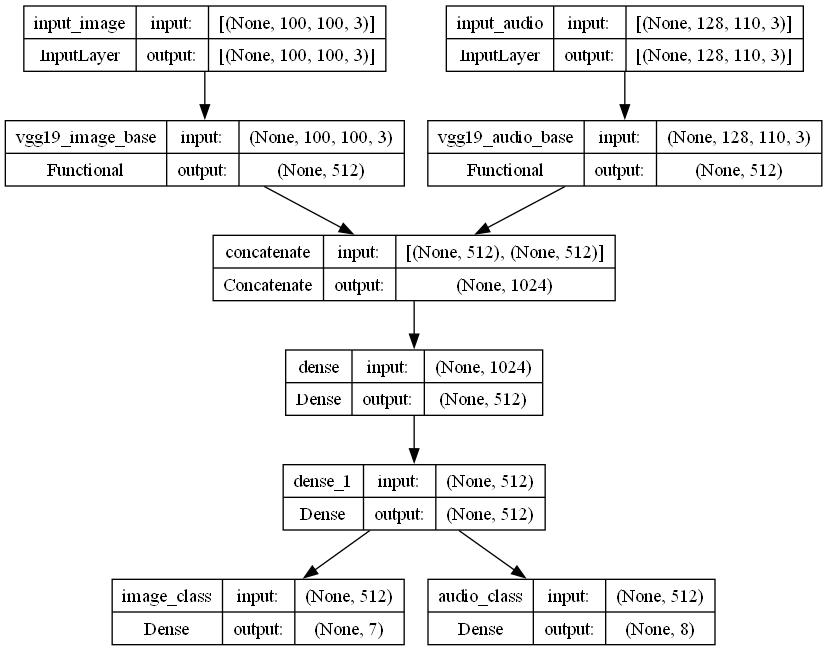

In [6]:
model = tf.keras.models.Model(inputs=[input_image, input_audio], outputs=[out1, out2])  
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-3),
    loss={
        'image_class': tf.keras.losses.SparseCategoricalCrossentropy(),
        'audio_class': tf.keras.losses.SparseCategoricalCrossentropy()
    },
    metrics={
        'image_class': 'accuracy',
        'audio_class': 'accuracy'
    }
)

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

In [ ]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    mode='min',
    # start_from_epoch=2,
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('model', 'best_model.keras'),
    verbose=2,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.2,
                                                    min_lr=1e-6,
                                                    patience=3,
                                                    mode='min'
                                                    )

## Train the model

In [ ]:
history = model.fit(
    x=[x_img_train, x_audio_train],
    y=[y_img_train, y_audio_train],
    validation_data=(
        [x_img_val, x_audio_val],
        [y_img_val, y_audio_val]
    ),
    callbacks=[lr_scheduler],
    epochs=100,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(x_img_train) // BATCH_SIZE,
    validation_steps=len(x_img_val) // BATCH_SIZE,
)


## Plot the model training result

In [ ]:
def plot_and_save(metric_name, history, ylabel, filename):
    plt.figure()
    plt.plot(history.history[metric_name], label=f'Train {ylabel}')
    if f'val_{metric_name}' in history.history:
        plt.plot(history.history[f'val_{metric_name}'], label=f'Val {ylabel}')
    plt.title(f'{ylabel} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [ ]:
plot_and_save('loss', history, 'Loss', 'loss_plot.png')
plot_and_save('image_class_loss', history, 'Image Classification Loss', 'image_class_loss_plot.png')
plot_and_save('audio_class_loss', history, 'Audio Classification Loss', 'audio_class_loss_plot.png')
plot_and_save('image_class_accuracy', history, 'Image Classification Accuracy', 'image_class_accuracy_plot.png')
plot_and_save('audio_class_accuracy', history, 'Audio Classification Accuracy', 'audio_class_accuracy_plot.png')

# Evaluation
## Using model.evaluate

In [ ]:
model.evaluate([x_img_val, x_audio_val], [y_img_val, y_audio_val], batch_size=BATCH_SIZE, verbose=2,
               steps=len(x_img_val) // BATCH_SIZE)

In [ ]:
model.evaluate([x_img_test, x_audio_test], [y_img_test, y_audio_test], batch_size=BATCH_SIZE, verbose=2,
               steps=len(x_img_test) // BATCH_SIZE)

In [ ]:
predictions = model.predict([x_img_test, x_audio_test], batch_size=BATCH_SIZE)

image_preds = predictions[0]
audio_preds = predictions[1]

## Using Confusion Matrix

In [ ]:
aud_classes = [x for x in os.listdir(AUDIO_PATH)]
img_classes = [x for x in os.listdir(TRAIN_IMAGE_PATH)]

image_class = np.argmax(predictions[0], axis=1)
audio_class = np.argmax(predictions[1], axis=1)

image_cm = confusion_matrix(y_img_test, image_class)
audio_cm = confusion_matrix(y_audio_test, audio_class)

In [ ]:
plt.figure(figsize=(10, 8))  # Set the figure size if needed
sns.heatmap(image_cm, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix Image', pad=20, fontsize=20, fontweight="bold")
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.xticks(ticks=range(len(img_classes)), labels=img_classes, rotation=45)
plt.yticks(ticks=range(len(img_classes)), labels=img_classes, rotation=0)
plt.savefig('confusion_matrix_image.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))  # Set the figure size if needed
sns.heatmap(audio_cm, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix Audio', pad=20, fontsize=20, fontweight="bold")
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.xticks(ticks=range(len(aud_classes)), labels=aud_classes, rotation=45)
plt.yticks(ticks=range(len(aud_classes)), labels=aud_classes, rotation=0)
plt.savefig('confusion_matrix_audio.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(classification_report(y_img_test, image_class))

In [ ]:
print(classification_report(y_audio_test, audio_class))

In [ ]:
model.save('model_sc2t4.h5')